In [1]:
# Import libraries 
# np, pd, plt,itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# sklearn
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

<b><font size = "4"> 1. Create data generating process function </font></b>

In [2]:
# Latent predictor data generating process
def latent(N=200,P=20,K=5):
    np.random.seed(1) # fix the simulation results
    #N = num. observations
    #K = num. predictors
    #P = num. observed predictors

    Z = np.random.randn(N,K)
    gamma = np.random.rand(K,P)
    X = np.dot(Z,gamma)+np.random.randn(N,P)
    beta = np.ones((K,1))
    y = np.dot(Z,beta) + np.random.randn(N,1)
    data = pd.DataFrame(np.concatenate((y,X),axis=1))

    return data,N,P,Z,X,y

In [3]:
# Sparse signal data generating process
def sparse(N=200,P=20,K=5):
    np.random.seed(1) # fix the simulation results
    #N = num. observations
    #K = num. predictors
    #P = num. observed predictors

    X = np.random.randn(N,P)
    Z = X[:,:K]
    beta = np.ones((K,1))
    y = np.dot(Z,beta) + np.random.randn(N,1)
    data = pd.DataFrame(np.concatenate((y,X),axis=1))

    return data,N,P,Z,X,y

<b><font size = "4">2. Generate and preprocess data</font></b>

In [4]:
# Generate "Latent" data
data,N,P,Z,X,y = latent(N=1000,P=20,K=5)

# Generate "Sparse" data
#data,N,P,Z,X,y = sparse(N=1000,P=20,K=5)

In [5]:
# Split training and test
X_train = data.iloc[:int(N/2),1:]
y_train = data.iloc[:int(N/2),0]
X_test = data.iloc[int(N/2):,1:]
y_test = data.iloc[int(N/2):,0]

# Standardize X
X_train = X_train.sub(np.mean(X_train,axis=0)).div(np.std(X_train,axis=0))
X_test = X_test.sub(np.mean(X_test,axis=0)).div(np.std(X_test,axis=0))

In [6]:
# Number of columns
ncol = len(X_train.iloc[0])

<b><font size = "4">3. Apply alogrithms</font></b>

3.1 Shrinkage

In [7]:
# Ridge CV
rcv = RidgeCV(cv=5)
rcv = rcv.fit(X_train,y_train)
cv_ridge_mse = mean_squared_error(rcv.predict(X_test),y_test)
print('RidgeCV MSE: ',cv_ridge_mse)

RidgeCV MSE:  1.18268269518466


In [8]:
# Lasso CV
lcv = LassoCV(cv=5)
lcv = lcv.fit(X_train,y_train)
cv_lasso_mse = mean_squared_error(lcv.predict(X_test),y_test)
print('LassoCV MSE: ',cv_lasso_mse)

LassoCV MSE:  1.1825003367163036


3.2 Feature extraction

In [9]:
# PCA
# Fit and transform PCA 
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Define Kfold
kf = KFold(n_splits=5,shuffle=True,random_state=1)

# Initalize regressor and MSE
regr = LinearRegression()
mse = []

# Loop for number of variables
for i in range(1,ncol+1):
    score = -1*cross_val_score(regr,X_train_pca[:,:i+1],y_train,cv=kf,scoring='neg_mean_squared_error').mean()
    mse.append(score)

# Number of companents with min MSE
best_nvar = np.argmin(mse)+1

# Obtain OOS MSE
regr = regr.fit(X_train_pca[:,:best_nvar+1],y_train)
cv_pca_mse = mean_squared_error(y_test,regr.predict(X_test_pca[:,:best_nvar+1]))
print('PCA CV MSE: ',cv_pca_mse)

PCA CV MSE:  1.188276665535775


In [10]:
# PLS
# Define Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Loop for number of variables
for i in range(1, ncol+1):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls,X_train,y_train,cv=kf,scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Number of companents with min MSE
best_nvar = np.argmin(mse)+1

# Obtain OOS MSE
pls = PLSRegression(n_components=best_nvar)
pls = pls.fit(X_train,y_train)
cv_pls_mse = mean_squared_error(y_test,pls.predict(X_test))
print('PLS CV MSE: ',cv_pls_mse)  

PLS CV MSE:  1.1830988488733103


3.3 Feature selection

In [11]:
# OOS_MSE function
def oos_mse(X_train,X_test,y_train,y_test):
    regr = LinearRegression()
    regr = regr.fit(X_train,y_train)
    mse = mean_squared_error(y_test,regr.predict(X_test))
    return mse

In [12]:
# Forward stepwise function
def forward_stepwise(X_train,X_test,y_train,y_test,nvmax=5,ncv=5,standardize=True):
    # Column names
    col_name = X_train.columns.values    
    
    # Standardize X
    if standardize:
        X_train = X_train.sub(np.mean(X_train,axis=0)).div(np.std(X_train,axis=0))
        X_test = X_test.sub(np.mean(X_test,axis=0)).div(np.std(X_test,axis=0))

    # Number of columns
    ncol = len(X_train.iloc[0])
    # Number of rows
    nrow = len(y_train)

    # Define Kfold
    kf = KFold(n_splits=ncv,shuffle=True,random_state=1)
    
    # Initalize attribute list and MSE
    attr = []
    mse = []  
    
    # Create a variable list for variable addition during the loop 
    remaining = col_name    
    
    # Forward stepwise loop
    regr = LinearRegression()
    for i in range(nvmax):
        # Intialize temp MSE list for holding the MSE of every trials
        temp_mse = [] 
        for var in remaining:
            attr_try = attr + [var]        
            score = cross_val_score(regr,X_train[attr_try],y_train,cv=kf,scoring='neg_mean_squared_error').mean()
            temp_mse.append(-score)
            
        best_var_id = np.argmin(temp_mse) # Locate index with lowest MSE
        attr.append(remaining[best_var_id]) # Append the best variable to attribute list
        remaining = list(set(remaining)-set(attr)) # Update the remaining attributes list 
        mse.append(np.min(temp_mse)) # Update MSE after adding one more variable
    
    best_var = attr[:np.argmin(mse)+1]
    cv_fw_mse = oos_mse(X_train[best_var],X_test[best_var],y_train,y_test)
    return cv_fw_mse

In [13]:
# Forward stepwise
cv_fw_mse = forward_stepwise(X_train,X_test,y_train,y_test,nvmax=7,ncv=5)
print('Forward Selection CV MSE: ',cv_fw_mse)

Forward Selection CV MSE:  1.311129850484197


In [14]:
# Best subset function
def best_subset(X_train,X_test,y_train,y_test,nvmax=5,ncv=5,standardize=True):
    # Column names
    col_name = X_train.columns.values    
    
    # Standardize X
    if standardize:
        X_train = X_train.sub(np.mean(X_train,axis=0)).div(np.std(X_train,axis=0))
        X_test = X_test.sub(np.mean(X_test,axis=0)).div(np.std(X_test,axis=0))

    # Number of columns
    ncol = len(X_train.iloc[0])
    # Number of rows
    nrow = len(y_train)

    # Define Kfold
    kf = KFold(n_splits=ncv,shuffle=True,random_state=1)
    
    # Initalize attribute list and MSE
    attr = []
    mse = []  
    
    # Create a variable list for variable addition during the loop 
    remaining = col_name    
    
    # Best subset loop
    regr=LinearRegression()
    for i in range(nvmax):
        for combo in itertools.combinations(col_name, i+1):           
            attr.append(list(combo)) #Create a attribute list for all possible combinations of attributes
            score = cross_val_score(regr,X_train[list(combo)],y_train,cv=kf,scoring='neg_mean_squared_error').mean()
            mse.append(-score)
    
    best_var = attr[np.argmin(mse)]
    cv_bs_mse = oos_mse(X_train[best_var],X_test[best_var],y_train,y_test)
    return cv_bs_mse

In [15]:
# Best subset
cv_bs_mse=best_subset(X_train,X_test,y_train,y_test,nvmax=7,ncv=5)
print('BEST SUBSET CV MSE: ',cv_bs_mse)

BEST SUBSET CV MSE:  1.3193944465999117


3.4 OLS without dimesnion reduction

In [16]:
# OLS
ols_mse = oos_mse(X_train,X_test,y_train,y_test)
print('OLS MSE: ',ols_mse)

OLS MSE:  1.1830996231146003


3.5 Oracle (True model)

In [17]:
# Oracle
oracle_data = pd.DataFrame(np.hstack((y,Z)))

# Split training and test
X_train = oracle_data.iloc[:int(N/2),1:]
y_train = oracle_data.iloc[:int(N/2),0]
X_test = oracle_data.iloc[int(N/2):,1:]
y_test = oracle_data.iloc[int(N/2):,0]

# Standardize X
X_train = X_train.sub(np.mean(X_train,axis=0)).div(np.std(X_train,axis=0))
X_test = X_test.sub(np.mean(X_test,axis=0)).div(np.std(X_test,axis=0))

# Obtain OOS MSE
regr=LinearRegression()
regr=regr.fit(X_train,y_train)
oracle_mse=mean_squared_error(y_test,regr.predict(X_test))
print('ORACLE MSE: ',oracle_mse)

ORACLE MSE:  0.9789935606967682


<b><font size = "4">Summary (MSE comparison among different models)<font></b>

Summary:
Oracle              0.978994
Lasso               1.182500
Ridge               1.182683
PLS                 1.183099
OLS                 1.183100
PCA                 1.188277
Forward stepwise    1.311130
Best subset         1.319394
dtype: float64


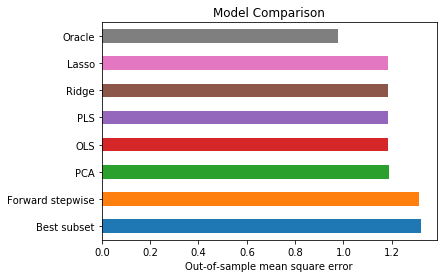

In [18]:
# Summary for model comparison
mse_summary = pd.Series({'Ridge':cv_ridge_mse,
                         'Lasso':cv_lasso_mse,
                         'PCA':cv_pca_mse,
                         'PLS':cv_pls_mse,
                         'Best subset':cv_bs_mse,
                         'Forward stepwise':cv_fw_mse,
                         'OLS': ols_mse,'Oracle':oracle_mse}).sort_values()

# Print summary
print('Summary:')
print(mse_summary)

# Plot summary
mse_summary[::-1].plot(kind='barh')
plt.xlabel('Out-of-sample mean square error')
plt.title('Model Comparison')
plt.show()